# Analysis for Gas Stock Price and Fuels used in GB Power Generation

# Program Code

#### _Importing Libraries_

In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr


from sklearn.svm import SVR
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

### <font color='salmon'>Code for 1st Objective - Data Analysis</font>

#### _Starting for Dataset for the Carbon Intensity API_

#### _Function: getDataForDates_
* _Takes as input start and end date -- Time span is 14 days (Suggested from API docs)_
* _Sends a request to the API and Checks if answer is 200 (valid)_
* _Returns the json data including all percentages of fuels used for generation._

In [2]:
def getDataForDates(url, start_date, end_date):
    r = requests.get("{}{}/{}".format(url, start_date, end_date))
    if r.status_code == requests.codes.ok:
        return r.json()
    else:
        print('Error --> {}'.format(r.status_code))

#### _Function: convertToDataFrame_
* _Takes as input the previous parsed json data._
* _creates a temp df used to reshape data._
* _returns the temp df and appends it on the main df (national_generation)._

In [3]:
def convertToDataFrame(data):
    df_index = pd.date_range(data['data'][0]['from'], data['data'][-1]['from'], freq='30min')
    cols = ['biomass', 'coal', 'imports', 'gas','nuclear', 'other','hydro','solar', 'wind']
    _df = pd.DataFrame(index=df_index, columns= cols)
    for i in range(len(df_index)):
        for j in range(9):
            col_name = data['data'][i]['generationmix'][j]['fuel']
            perc = data['data'][i]['generationmix'][j]['perc']
            _df.loc[df_index[i], col_name] = float(perc)
    return _df

#### _Fetching data_
* _Itarates on a daterange with a 14 day frequency -- as suggested from API)._
* _Uses parseFromApi to parse half hourly data from the API._
* _Uses fromJsonToDf to return the reshaped dataframe._
* _Creates the final df national_generation._
* _Storing my data locally as .pkl to avoid calling repeatedly the API._
* _Running time should be about 3 minutes_

In [4]:
url = 'https://api.carbonintensity.org.uk/generation/'
date_range = pd.date_range('2019-01-01', '2021-01-01', freq='14D')
temp_list = []

for i in range(len(date_range)-1):
    r_json = getDataForDates(url, date_range[i].date(), date_range[i+1].date())
    temp_list.append(convertToDataFrame(r_json))

national_generation = pd.concat(temp_list)

#### _Function: checkWkdaysOrBdays_
_Takes as input a series with dates returns if this series has Business days, Holidays, both or None. It is used as helper for some reconcilliations._

In [5]:
def checkWkdaysOrBdays(series):
    """takes as input a Series with dates returns an answer based on 
    if this series has Business days, Holidays, both or None"""
    counter_for_b_days = len(pd.bdate_range(series.index.min(), series.index.max()))
    
    if len(series) == counter_for_b_days:
        return 'All values are Business days'
    elif len(series) != counter_for_b_days and counter_for_b_days != 0:
        return 'The values are both Business days and holidays'
    elif counter_for_b_days == 0:
        return 'All values are holidays'
    else:
        return 'Houston we have a problem!'

#### _Function: updateDataset_
_After fetching the first dataset the user will be able to use this function to update their dataset for future projects_

In [6]:
def updateDataset(last_date, url):
    """
    step1) Takes the url for the api and as input the last date 
    step2) Checks if the last date is valid, if yes it creates a date range and parses from the api JSON data. 
    step3) Stores those data in a temp df.
    step4) Checks if  there exist any days that werent included in the date range (defalt day frequency 14D)
    step5) If yes parses the rest and returns temp_df HH data. Else returns temp_df HH data.
    """

    previous_last_date = national_generation.index.max()
    last_date = pd.to_datetime(last_date)
    temp_df = pd.DataFrame()
    
    if last_date <= pd.to_datetime('today') and last_date > previous_last_date:
        print('valid date, fetching from API')
    else:
        print('last date is not valid, please double check you inputs')
        return None

    date_range = pd.date_range(previous_last_date, last_date, freq='14D')
    
    for i in range(len(date_range)-1):
        r_json = getDataForDates(url, date_range[i].date(), date_range[i+1].date())
        temp_df = temp_df.append(convertToDataFrame(r_json))

    if date_range.max() != last_date:
        date_range = pd.date_range(date_range.max(), last_date)
        r_json = getDataForDates(url, date_range[i].date(), date_range[i+1].date())
        temp_df = temp_df.append(convertToDataFrame(r_json))
        return temp_df
    else:
        return temp_df

#### _Inspecting First Dataset_

In [7]:
national_generation.head(2)

,biomass,coal,imports,gas,nuclear,other,hydro,solar,wind
2018-12-31 23:30:00+00:00,4.2,0.0,6.0,24.3,27.0,0.2,1.6,0.0,36.7
2019-01-01 00:00:00+00:00,4.1,0.0,6.9,22.8,27.3,0.2,1.6,0.0,37.1


In [8]:
# Dropping the first record because it parsed the last half-hour of 2018
national_generation = national_generation.iloc[1:,:]

In [9]:
print('Info about the dataset:\n')
print(national_generation.info())

Info about the dataset:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34370 entries, 2019-01-01 00:00:00+00:00 to 2020-12-28 23:30:00+00:00
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   biomass  34370 non-null  object
 1   coal     34370 non-null  object
 2   imports  34370 non-null  object
 3   gas      34370 non-null  object
 4   nuclear  34370 non-null  object
 5   other    34370 non-null  object
 6   hydro    34370 non-null  object
 7   solar    34370 non-null  object
 8   wind     34370 non-null  object
dtypes: object(9)
memory usage: 2.6+ MB
None


#### _Comment on above code_
_I can see that the columns should be changed to float (percentages) and the index to Datatime (timeseries)_

#### _Function changeDtypes: Cleaning and storing First Dataset_
* _Changing the index into datetime and also all columns from objects to floats._
* _Checking if my daily percent share of fuels adds up to 100% to ensure that I haven't messed up my dataset during step 3._
* _Storing first dataset locally._

In [10]:
def changeDtypes(temp_df):
    """changin the type of index and cols"""
    temp_df.index = temp_df.index.astype('datetime64[ns]')
    temp_df = temp_df.apply(lambda x: x.astype(float))
    temp_df = temp_df.round(decimals=4)
    return temp_df

In [11]:
national_generation = changeDtypes(national_generation)

In [12]:
national_generation = national_generation.resample('D').mean()

In [13]:
print('We have Null Values' if national_generation.isnull().any().any() else 'Data Is Clean')

We have Null Values


#### _Cleaning the null values_
* _Realised that I have null values that may exist because of bank holidays._
* _Created a dataframe including only the null values._
* _Created a loop tha will return a series which will have either 1 if it was business day else 0._
* _Compared the null df with the series to obtain a better view of the dataset._

In [14]:
checkWkdaysOrBdays(pd.Series(national_generation[national_generation.isnull()].index))

'The values are both Business days and holidays'

#### _Comment on above code_
The previous check was to understand if the API specifically excludes weekend in case of null values.

In [15]:
national_generation.dropna(inplace=True)
print('We have Null Values' if national_generation.isnull().any().any() else 'Data Is Clean')

Data Is Clean


#### _Sum Per Record_
As mentioned previously, the sum per row must be 100% to have a valid record.

In [16]:
print('Result --> {:.2f}%'.format(national_generation.sum(axis=1).mean()))
if round(national_generation.sum(axis=1).mean(),2) == 100:
    print('Dataset 1 is ready to be stored as .pkl File')
else:
    print('Huston we have a problem')

Result --> 100.00%
Dataset 1 is ready to be stored as .pkl File


In [17]:
# national_generation.to_pickle('two_year_data.pkl')

#### _Updating local dataset future use_
* _The user will be able to update thier databased simply by giving the date they want to update_
* _The logic is similar with previously;_
    1. the updateDataset will return the updated dataframe -- for more info use print(updateDataset.__doc__).
    2. cleans the data
    3. resamples -- in this step resample will return all the dates that were missing as Nan to fill in the gaps
    4. checks if they were week days or Bdays.
    5. asks the users if they want to append the table or if they think that something maybe wrong with the API.
    6. append to df with all the dates
    7. deletes the temporary df and appends the updated values into pkl.
* _For my exercise I will keep the same dates because I want to compare exactly two years. So this part of code is commended. Also, if you want to compare a new dataset please change the gas at the same day and rerun it._

In [18]:
# updated_df = updateDataset('2021-01-28', 'https://api.carbonintensity.org.uk/generation/')
# updated_df = cleanData(updated_df)
# updated_df = updated_df.resample('D').mean()

# if updated_df.isnull().any().any():
#     print('the new dataset has null values')
#     answer = checkWkdaysOrBdays(pd.Series(updated_df.index))
#     print(answer)
#     if input('do you still want to, drop na values and append to existing dataset? please answer: y or n: ') == 'y':
#         updated_df.dropna(inplace=True)
#         national_generation = national_generation.append(updated_df)
# del updated_df
# national_generation.to_pickle('two_year_data.pkl')

#### _Fetching and Inspecting Second Dataset_

In [19]:
gas = pdr.get_data_yahoo('NG=F', start=pd.to_datetime('01/01/2019').date(), end=pd.to_datetime('01/01/2021').date())

In [20]:
gas.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,3.039,2.905,2.921,2.958,147676,2.958
2019-01-03,3.011,2.878,2.963,2.945,115803,2.945


In [21]:
print('General INFO:\n')
print(gas.info())

General INFO:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2019-01-02 to 2020-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       505 non-null    float64
 1   Low        505 non-null    float64
 2   Open       505 non-null    float64
 3   Close      505 non-null    float64
 4   Volume     505 non-null    int64  
 5   Adj Close  505 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 27.6 KB
None


#### _Comment on previous step_
_This dataset is ready so I can store the data locally without changing anything._

In [22]:
# gas.to_pickle('gas.pkl')

#### Comment on all previous steps
_At that point the 1st Objective "Data Analysis" (fetching, investigating, cleaning and storing our data) is finished._

#### _Calling again the datasets_

_The below code calls again the finshed datasets -- it helped avoid unnecessary calls to the APIs._

In [23]:
# national_generation = pd.read_pickle('two_year_data.pkl')
# gas = pd.read_pickle('gas.pkl')
cols_fuels = ['biomass', 'coal', 'imports', 'gas', 'nuclear', 'other', 'hydro', 'solar', 'wind']
cols_stocks = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
# national_generation = changeDtypes(national_generation)

### <font color='salmon'>_Code for 2nd Objective - Data Visualisation_</font>

Creating functions for visualisation that are called afterwards to maintain a cleaner results section.

In [24]:
def plotHistograms(df, cols, x_subplot_number, y_subplots_number,subtitle):
    """Returning Histograms of the whole dataset"""
    fig, ax = plt.subplots(x_subplot_number, y_subplots_number, figsize=(16, 10))
    counter = 0
    for x_axis in range(x_subplot_number):
        for y_axis in range(y_subplots_number):
            n_bins = np.histogram_bin_edges(df.loc[:, cols[counter]], bins='auto')
            sns.histplot(df.loc[:, cols[counter]], ax=ax[x_axis,y_axis], kde=True, color='salmon', bins=n_bins)
            counter+=1
    plt.suptitle(subtitle, fontsize=20)
    sns.set_style("darkgrid")

In [25]:
def plotPieChart(data,explode, graph_title, y_label):
    """Returning pie plot revealing the % per fuel"""
    fig = data.plot.pie(autopct="%.1f%%", 
                        pctdistance=0.9,
                        explode=explode,
                        shadow = False,
                        startangle = 90,
                        figsize=(7.5,5.5),
                        title=graph_title,
                        ylabel= y_label,
                        wedgeprops = {"edgecolor" : "brown",
                                      'linewidth' : 1,
                                      'antialiased': True})

In [26]:
def printSummerWinterCV(summer, winter):
    """calculates the coefficient of variation and prints a df illustrating summer, winter and diff."""
    summer_cv = summer.describe().iloc[2,:] / summer.describe().iloc[1,:]
    winter_cv = winter.describe().iloc[2,:] / winter.describe().iloc[1,:]
    temp_df = (pd.DataFrame(data = [summer_cv,winter_cv]).T)
    temp_df.rename(columns={0:'summer', 1:'winter'},inplace=True)
    temp_df['difference'] = temp_df['summer'] - temp_df['winter']
    print(temp_df)

In [27]:
def plotTwoLineGraphs(series_1, series_2,fig_size):
    """plotting two series against each other"""
    series_1.plot(color='green', lw=3, alpha=0.3, label=series_1.name,figsize=fig_size)
    series_2.plot(color='blue', lw=3, alpha=1.5, label=series_2.name,figsize=fig_size)
    plt.legend(loc='lower right')

### <font color='salmon'>_Code for 3rd Objective - ML pipeline_</font>

#### _Creating the dataset for ML_
* _Merging the two tables_
* _Picking High as dependant variable & the fuels used for electricity generation as independant (wind excluded because of multicollinearity with gas)_

In [28]:
merged_df = pd.merge(gas['High'],national_generation,how='inner' ,left_index=True, right_index=True)

In [29]:
merged_df.isnull().any()

High       False
biomass    False
coal       False
imports    False
gas        False
nuclear    False
other      False
hydro      False
solar      False
wind       False
dtype: bool

#### Preprocessing
* There was an inconsistency between the dependant and independent variables.<br>
The latter was in percentages and the former with USD. To tackle this problem, we have used a standard scaler.

#### ML model:
* For the prediction, the SVR method was used with default hyperparameters.

In [30]:
y = merged_df['High'] # dependent var
x = merged_df[['biomass', 'coal', 'imports', 'gas', 'nuclear', 'other', 'hydro', 'solar']] # independent var
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
pipe.fit(x_train, y_train)
y_predict = pipe.predict(x_test)

# Project Outcome

## Overview of Results
On average, in 2019 and 2020, only 33% of fuels were generated from green sources, while gas and nuclear, produced nearly 60% of the total energy. However, coal consumption until the end of 2020 was at nearly zero level

Wind showed that it could reliably supply 20% of the total power generation and seems to be a very efficient energy source.In contrast, hydro only produced 2% of the total, and solar is highly correlated with the weather conditions as it showed high CV during winter. These results indicate it would be meaningful to invest more in offshore wind farms rather than other sources.

Additionally, the imports of fuels used for power generation were at 7.5% of the total, which indicates that the infrastructure of GB alone cannot cover its market -- exposing them to the risk of other markets. This information led to set the third objective, investigating if this supply and demand relationship could not only be theoretical but have a practical use in predicting the movements of a stock commodity.

The model delivered a prediction with r squared 0.8 with a MAPE of 5%.

## Objective 1 _(Data Analysis)_

### Overview of the steps

Data Analysis aimed to fetch, clean, store locally the two datasets and enable the user to update them in the future.
In particular:

For the Carbon Intensity API:
1. Used day frequency to 14 days as suggested from its documentation.
2. Transformed the data from JSON to tabular form (DataFrame)
3. Did several inspections to check the validity of the data and cleaned the dataset:
	1. changed index/ columns' type
	2. checked for null values and if they have any relatioship with holidays or weekdays.
	3. checked sum per recond.
4. Created the local file with the first two years of data
5. Created a function to allow users to update their data when they want to do the same analysis in the future.

For the Yahoo finance API:
1. Fetched the data
2. checked for any errors
3. stored them locally
4. Updating the dataset in the future -- the user can simply reuse the API as the dataset is small (daily).

## Objective 2 _(Data Visualization)_

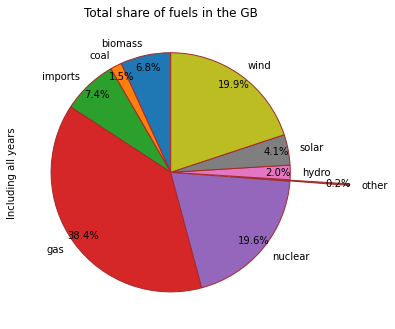

In [31]:
explode=[0,0,0,0,0,0.5,0,0,0]
plotPieChart(national_generation.mean(), explode, 'Total share of fuels in the GB', 'Including all years')

#### <font color='salmon'>Comment of above code: Overview from 2019 to 2021:</font>

* Overall nearly 80% of the power generation is coming for 3 sources; gas, nuclear and wind.

* Coal is only 1.5% on of power generation on average. This is a very good sign given the decarbonisation targets of the GB.

* From the total generation of electricity approximatelly 33% is coming from a green fuels (biomass, hydro, solar, wind).

* The only green fuel that produced energy at a comparable level to gas and nuclear is wind.

In [32]:
national_generation.resample('Y').mean()

,biomass,coal,imports,gas,nuclear,other,hydro,solar,wind
2019-12-31,6.448721,1.819302,7.41147,40.563068,20.087576,0.284999,1.823902,3.819614,17.741348
2020-12-31,7.166454,1.269212,7.47749,36.126643,19.115886,0.143279,2.097531,4.432437,22.171281


#### <font color='salmon'>Comment for above graph: Overview per year:</font>
* Simillar patterns are shown in terms of the share of fuels on the overall for all of the three years of our dataset.

* Wind has increased by 4.37%, while, gas has dropped by 4.38%.

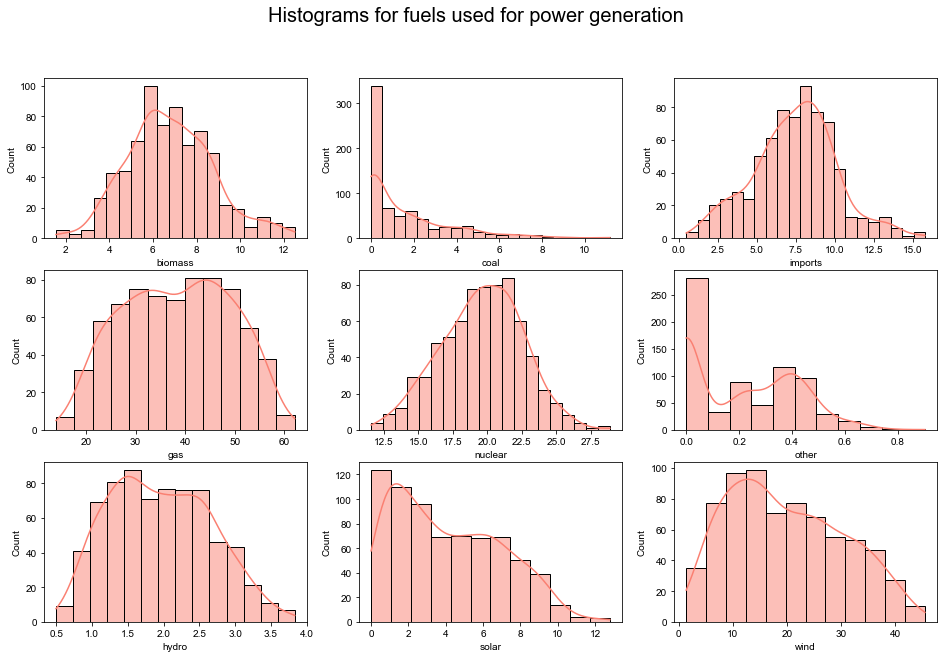

In [33]:
plotHistograms(national_generation, cols_fuels,3,3, 'Histograms for fuels used for power generation')

#### <font color='salmon'>Comments for above Histograms</font>
* Used np.histogram_bin_edges for bin number, with bins='auto'. Picking the best of sturges and Freedman Diaconis. Both are robust formulas to calculate bins.

* It seems that Biomass, nuclear and imports have the same patterns. However, it is not easy to undertand exactly how 
much they flactuate. Hence,  the coefficient of variation (CV = st.div. / mean) will be used below for further analysis.

In [34]:
print('The coefficient of variation is: \n\n{}'.format(national_generation.describe().iloc[2,:] /
                                                       national_generation.describe().iloc[1,:]))

The coefficient of variation is: 

biomass    0.289090
coal       1.319081
imports    0.359001
gas        0.280759
nuclear    0.150300
other      0.938216
hydro      0.359278
solar      0.693674
wind       0.527435
dtype: float64


#### <font color='salmon'>Comments for CV</font>
Although one would expect that green energy would flactuate a lot, it seems that except from "coal" and "other" all other sources of energy are pretty stable (rule of thumb CV < 1).

#### <font color='salmon'>Dividing my dataset into Winter and Summer</font>
* Check if this behaivior is affected from the weather conditions.
* This time only the CV will be calculated.

In [35]:
summer_subset = national_generation[national_generation.index.month.isin([4,5,6,7,8,9])]
winter_subset = national_generation[~(national_generation.index.month.isin([4,5,6,7,8,9]))]
printSummerWinterCV(summer_subset, winter_subset)

           summer    winter  difference
biomass  0.308807  0.249731    0.059076
coal     1.853386  0.828379    1.025007
imports  0.421912  0.280462    0.141450
gas      0.276130  0.283764   -0.007634
nuclear  0.155622  0.142568    0.013055
other    1.176303  0.735492    0.440812
hydro    0.359570  0.261195    0.098376
solar    0.354631  0.790030   -0.435399
wind     0.557883  0.481456    0.076427


#### Summary for Summer and Winter
The only significant flactuation between summer and winter was in other and solar -- meaning that only these two sources were affected from weather.

#### <font color='salmon'>Correlation table including all data</font>

In [36]:
national_generation.corr(method ='pearson').style.background_gradient(cmap='Pastel2')

,biomass,coal,imports,gas,nuclear,other,hydro,solar,wind
biomass,1.000000,-0.109783,0.163072,0.029062,0.036298,-0.134394,-0.157645,0.209370,-0.291132
coal,-0.109783,1.000000,-0.170531,0.164754,-0.291741,0.285609,0.210449,-0.553197,-0.086951
imports,0.163072,-0.170531,1.000000,-0.158823,0.142584,-0.009744,-0.022820,0.154388,-0.169088
gas,0.029062,0.164754,-0.158823,1.000000,-0.385227,-0.142206,-0.287783,-0.090437,-0.868571
nuclear,0.036298,-0.291741,0.142584,-0.385227,1.000000,-0.018356,0.048008,0.130495,0.090009
other,-0.134394,0.285609,-0.009744,-0.142206,-0.018356,1.000000,0.224373,-0.138250,0.126462
hydro,-0.157645,0.210449,-0.022820,-0.287783,0.048008,0.224373,1.000000,-0.395924,0.312598
solar,0.209370,-0.553197,0.154388,-0.090437,0.130495,-0.138250,-0.395924,1.000000,-0.157523
wind,-0.291132,-0.086951,-0.169088,-0.868571,0.090009,0.126462,0.312598,-0.157523,1.000000


#### <font color='salmon'>Comments for above table:</font>
Overall it seems that there is not significant correlation between the data -- with only exception the relationship between gas and wind.

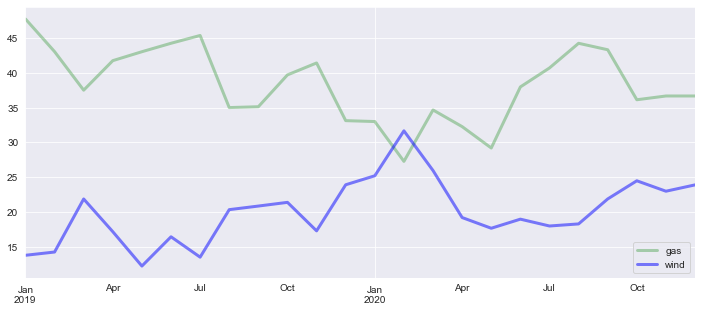

In [37]:
# Plotting gas vs wind
plotTwoLineGraphs(national_generation.resample('M').mean()['gas'], 
                  national_generation.resample('M').mean()['wind'],(12,5))

## Objective 3 _(Machine Learning: understanding and predicting gas stock prices by using fuels)_
### Explanation of Results

Starting from the price of gas:
1. All prices with except the volume are highly correlated .
2. Gas had a free fall from October 2019 to March 2020, but seven months later was at the same level.

ML model:

Predicting stock prices is a complicated task for a commodity like gas. However, it seems that these data alone can predict the gas movements and deliver good results. In particular, we have an R_2 score of 0.8 (rule of thumb R2 > 0.7) and MAE, RMSE and MSE relatively low.


### Visualisation

#### <font color='salmon'>Visualisation for Gas stock Price</font>

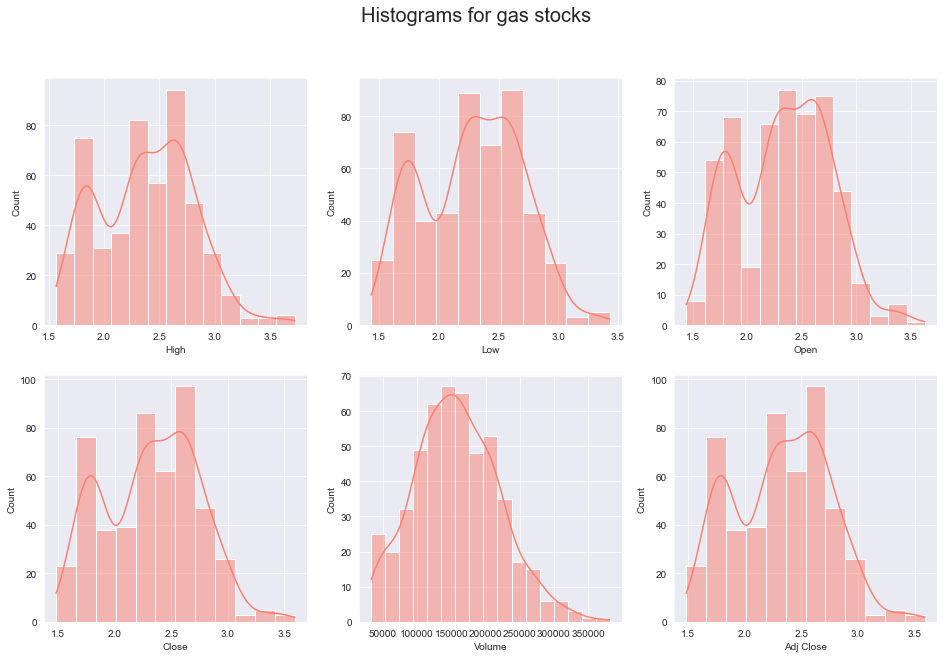

In [38]:
plotHistograms(gas, cols_stocks, 2, 3, 'Histograms for gas stocks')

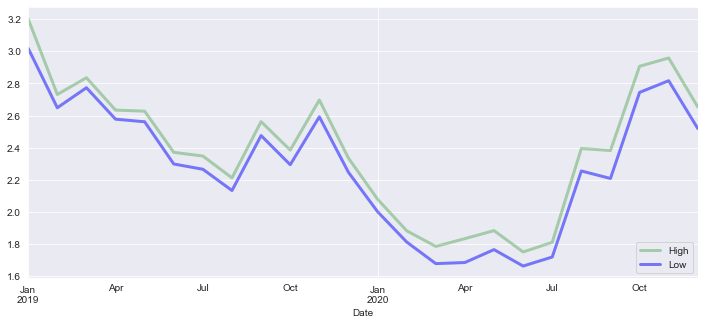

In [39]:
plotTwoLineGraphs(gas.resample('M').mean()['High'], 
                  gas.resample('M').mean()['Low'],(12,5))

In [40]:
gas.describe()

,High,Low,Open,Close,Volume,Adj Close
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,2.383198,2.278560,2.331711,2.327846,158029.134653,2.327846
std,0.425481,0.416441,0.421096,0.420791,62235.565133,0.420791
min,1.567000,1.432000,1.441000,1.482000,32525.000000,1.482000
25%,1.978000,1.872000,1.936000,1.924000,115412.000000,1.924000
50%,2.392000,2.289000,2.341000,2.334000,154549.000000,2.334000
75%,2.692000,2.600000,2.645000,2.636000,200414.000000,2.636000
max,3.722000,3.433000,3.631000,3.591000,381969.000000,3.591000


In [41]:
gas.corr(method ='pearson').style.background_gradient(cmap='Pastel2')

,High,Low,Open,Close,Volume,Adj Close
High,1.000000,0.991642,0.993435,0.994278,-0.186499,0.994278
Low,0.991642,1.000000,0.994067,0.994055,-0.227642,0.994055
Open,0.993435,0.994067,1.000000,0.987135,-0.208713,0.987135
Close,0.994278,0.994055,0.987135,1.000000,-0.210506,1.000000
Volume,-0.186499,-0.227642,-0.208713,-0.210506,1.000000,-0.210506
Adj Close,0.994278,0.994055,0.987135,1.000000,-0.210506,1.000000


#### <font color='salmon'>Comments for the above for gas:</font>
* Both high and low have exactly the same trends.
* All values except Volume are showing the same distribution, this can be noticed both from the histograms and the correlation table.

#### <font color='salmon'>ML model Results</font>

In [42]:
print("r2_score --> {:.3f}".format(pipe.score(x_test, y_test)))
print("MAPE --> {:.3f}%".format(np.mean(np.abs((y_test - y_predict) / y_test)) * 100))

r2_score --> 0.857
MAPE --> 5.297%


# Conclusions

### Acheivements

To wrap up, from the first dataset we conjecture that wind is a very efficient form of clean energy that can adequetly replace other less clean forms like gas. Also, the GB was importing 7.5% of its energy from foreign countries, which led us to build an SVR model to predict a foreign commodity (gas USA) using the first dataset as predictor. The results showed that the relationship of these countries drives a co-movement between the datasets, and these fuels delivered a reasonably good model. 

### Future Work


In the future, it would be good to check the same relationships in more extended periods or exclude the period of COVID. Also, one could focus more on the machine learning side and, instead of a simple model, try to implement a more sophisticated model incorporating variables like political news, the weather and others.